# Linear regression, overfitting and regularization

In [2]:
import numpy as np
import matplotlib.pyplot as plt

If we don't include enough basis functions, we will *underfit* our data. For example, if some points lie exactly along a cubic curve: 

In [3]:
N = 100; D = 1
X = np.random.randn(N, D) - 0.5
ys = X**3

We will not be able to fit this data accurately if we only put linear and quadratic basis functions in our augmented design matrix $\Phi$.

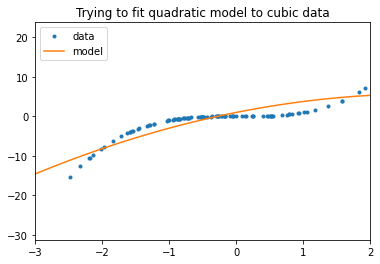

In [4]:
# Augment X with 1s and X**2 columns
Phi = np.hstack([np.ones((N, 1)), X, X**2])

# Fit least squares
w_fit = np.linalg.lstsq(Phi, ys, rcond=None)[0]

# Prepare grid of points to evaluate the model
left = -3; right = 2
plt.xlim(left, right)
X_grid = np.linspace(left, right, 100)[:, None]
Phi_grid = np.hstack([np.ones((100, 1)), X_grid, X_grid**2])
ys_grid = Phi_grid @ w_fit

# Plot the data and the model
plt.plot(X, ys, '.', X_grid, ys_grid, '-')
plt.title("Trying to fit quadratic model to cubic data")
plt.legend(['data', 'model'])
plt.show()

##  Examples of what overfitting can look like

*Example 1: Fitting many features.* 

In [5]:
N = 150; D = 100
# mu^n ~ Uniform(0, 1) for n = 1, ..., N
mu = np.random.rand(N)
# x_d^n ~ Normal(mu_n, 0.01) for d = 1, ..., D and n = 1, ..., N
Phi = np.random.randn(N, D) * 0.01 + mu[:, None]
# y^n ~ Normal(mu_n, 0.1) for n = 1, ..., N
ys = 0.1 * np.random.randn(N) + mu


Averaging the $x_d$ measurements would be a reasonable estimate of the underlying $\mu$ and, hence, of output $y$. Thus a regression model with $w_d = \frac 1 D$ would do alright.

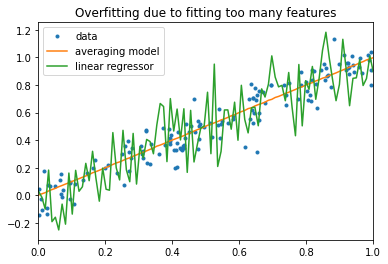

In [6]:
# "Fit" model which averages over all features
w_ave = np.ones(D) / D

# Fit linear regression model
w_fit = np.linalg.lstsq(Phi, ys, rcond=None)[0]

# Prepare grid to evaluate the models
left = 0; right = 1; N_grid = 100
plt.xlim(left, right)
mu_grid = np.linspace(left, right, N_grid)[:, None]
Phi_grid = np.random.randn(N_grid, D) * 0.01 + mu_grid
ys_grid_ave = Phi_grid @ w_ave
ys_grid_fit = Phi_grid @ w_fit

# Plot
plt.plot(mu, ys, '.', mu_grid, ys_grid_ave, '-', mu_grid, ys_grid_fit, '-')
plt.legend(['data', 'averaging model', 'linear regressor'])
plt.title("Overfitting due to fitting too many features")
plt.show()

*Example 2: Explaining noise with many basis functions.*

In [7]:
N = 100; 

# X ~ Uniform(0, 1)
X = np.random.rand(N, 1)
# ys ~ Normal(0, 1)
ys = np.random.randn(N)

X and ys have no relationship, the best predictor (by least-squares) on unseen data would be $f(\mathbf x) = 0$. Using many basis functions may lower the training error, but lead to a larger expected error in the feature. 

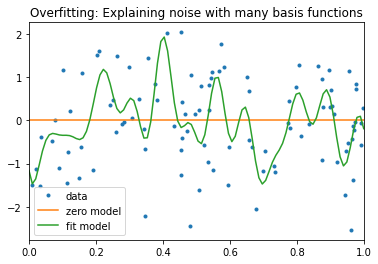

In [8]:
# RBF
# @param xs: input vector
# @param c: center
# @param h: bandwidth
# @return: output vector
def rbf_1d(xs, c, h):
    return np.exp(-((xs - c) ** 2) / (h ** 2))

# Create design matrix out of 20 basis functions
K = 30
centers = np.linspace(0, 1, K) # K, 1
Phi = np.hstack([rbf_1d(X, c, 0.1) for c in centers]) # N, K

# "Fit" 0 model 
w_zero = np.zeros(K) # K, 1

# Fit the model using least squares
w_fit = np.linalg.lstsq(Phi, ys, rcond=None)[0] # K, 1

# Prepare grid to evaluate the models
left = 0; right = 1; N_grid = 100
plt.xlim(left, right)
X_grid = np.linspace(left, right, N_grid)[:, None] # N_grid, 1
Phi_grid = np.hstack([rbf_1d(X_grid, c, 0.1) for c in centers]) # N_grid, K

# Evaluate models
ys_grid_zero = Phi_grid @ w_zero # N_grid, 1
ys_grid_fit = Phi_grid @ w_fit # N_grid, 1

# Plot
plt.plot(X, ys, '.', X_grid, ys_grid_zero, '-', X_grid, ys_grid_fit, '-')
plt.legend(['data', 'zero model', 'fit model'])
plt.title("Overfitting: Explaining noise with many basis functions")
plt.show()

## L2 Regularization

One form of regularization is to penalize the sum of the square weights in our cost function. 

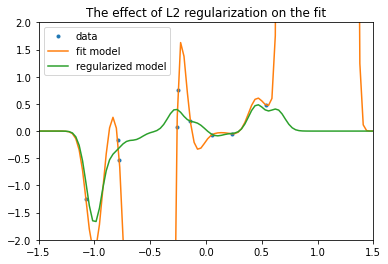

In [21]:
# E.g, generate cubic data with noise. 
N, D = 15, 1
X = np.random.randn(N, D) # N, 1
ys = X**3 + 0.3 * np.random.randn(N)[:, None] # N, 1

# Consider a dozen RBF basis functions
K = 12
centers = np.linspace(-1, 1, K) # K, 1
Phi = np.hstack([rbf_1d(X, c, 0.1) for c in centers]) # N, K

# Try fitting a linear regressor to the data
w_fit = np.linalg.lstsq(Phi, ys, rcond=None)[0] # K, 1

# Fit another model that uses L2 regularization
ys_reg = np.vstack([ys, np.zeros(K)[:, None]]) # N + K, 1
lambda_reg = 0.1
Phi_reg = np.vstack([Phi, np.sqrt(lambda_reg) * np.eye(K)]) # N + K, K
w_reg = np.linalg.lstsq(Phi_reg, ys_reg, rcond=None)[0] # K, 1

# Prepare a grid for plotting
left = -1.5; right = 1.5; N_grid = 100
plt.xlim(left, right)
X_grid = np.linspace(left, right, N_grid)[:, None]
Phi_grid = np.hstack([rbf_1d(X_grid, c, 0.1) for c in centers])
ys_grid_fit = Phi_grid @ w_fit
ys_grid_reg = Phi_grid @ w_reg

# Plot
plt.plot(X, ys, '.', X_grid, ys_grid_fit, '-', X_grid, ys_grid_reg, '-')
plt.ylim(-2, 2)
plt.legend(['data', 'fit model', 'regularized model'])
plt.title("The effect of L2 regularization on the fit") 
plt.show()